## Model Training

### Import required packages

In [130]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

#### Import the cleaned CSV Data as Pandas DataFrame

In [131]:
df = pd.read_csv('data/cleaned_cargo_data.csv')

### Top 5 and Bottom 5 rows

In [132]:

df.head()

,gender,race_ethnicity,level_of_education,language_proficiency,training_manuals,pre_exams_average,Certification_exam_Outcome
0,male,group A,high school,fluent,none,66.0,0
1,female,group E,some college,intermediate,provided,87.0,1
2,male,group A,some college,fluent,none,48.0,0
3,female,group E,some college,fluent,provided,75.0,1
4,male,group E,some college,fluent,none,71.0,1


In [133]:
df.tail()

,gender,race_ethnicity,level_of_education,language_proficiency,training_manuals,pre_exams_average,Certification_exam_Outcome
1112,female,group C,NaN,fluent,provided,84.0,1
1113,female,group E,master's degree,intermediate,none,56.0,0
1114,male,group D,master's degree,fluent,none,80.0,1
1115,female,group C,master's degree,intermediate,provided,81.0,1
1116,female,group D,master's degree,fluent,provided,87.0,1


In [134]:
df.dropna(inplace=True)

## <font color=blue>Split Dataset</font>

In [135]:
X = df.drop(columns=['Certification_exam_Outcome'],axis=1)

In [136]:
X.head()

,gender,race_ethnicity,level_of_education,language_proficiency,training_manuals,pre_exams_average
0,male,group A,high school,fluent,none,66.0
1,female,group E,some college,intermediate,provided,87.0
2,male,group A,some college,fluent,none,48.0
3,female,group E,some college,fluent,provided,75.0
4,male,group E,some college,fluent,none,71.0


In [137]:
X.shape

(1095, 6)

### Categorical Columns

In [138]:
# unique values in cat columns
print("Categories in 'gender' variable:     ",end=" " )
print(df['gender'].unique())

print("Categories in 'race_ethnicity' variable:  ",end=" ")
print(df['race_ethnicity'].unique())

print("Categories in'level of education' variable:",end=" " )
print(df['level_of_education'].unique())

print("Categories in 'language proficiency' variable:     ",end=" " )
print(df['language_proficiency'].unique())

print("Categories in 'training manuals' variable:     ",end=" " )
print(df['training_manuals'].unique())

Categories in 'gender' variable:      ['male' 'female' 'other']
Categories in 'race_ethnicity' variable:   ['group A' 'group E' 'group B' 'group D' 'group C']
Categories in'level of education' variable: ['high school' 'some college' 'some high school' "associate's degree"
 "bachelor's degree" "master's degree"]
Categories in 'language proficiency' variable:      ['fluent' 'intermediate' 'limitted']
Categories in 'training manuals' variable:      ['none' 'provided']


In [139]:
# replace the gender with 'Other' values with mode of the col
mode_gender = df['gender'].mode()[0]
print(mode_gender)
# Replace 'Other' values with the mode value
df['gender'] = df['gender'].replace('other', mode_gender)

female


In [140]:

print(df['gender'].unique())

['male' 'female']


In [141]:
y = df['Certification_exam_Outcome']

In [142]:
y.shape

(1095,)

In [143]:
y


0       0
1       1
2       0
3       1
4       1
       ..
1111    0
1113    0
1114    1
1115    1
1116    1
Name: Certification_exam_Outcome, Length: 1095, dtype: int64

In [144]:
# Create Column Transformer with 3 types of transformers
#  categorical features using OneHotEncoder,
# numeric features using StandardScaler.
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [145]:

X_preprocessed = preprocessor.fit_transform(X)

In [146]:
X_preprocessed.shape

(1095, 20)

### Handling imbalanced data

In [147]:
y.value_counts()

Certification_exam_Outcome
1    620
0    475
Name: count, dtype: int64

In [148]:
from imblearn.over_sampling import SMOTE

In [149]:
X_resampled, y_resampled =SMOTE().fit_resample(X_preprocessed,y)

In [150]:
y_resampled.value_counts()

Certification_exam_Outcome
0    620
1    620
Name: count, dtype: int64

In [151]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((992, 20), (248, 20))

In [152]:
X_train.shape

(992, 20)

In [153]:
X_train

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  1.45817344],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         1.        ,  0.01251084],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.21903407],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  1.        ,
         0.        , -0.90293155],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         1.        ,  0.35671622],
       [ 0.        ,  1.        ,  0.        , ...,  1.        ,
         0.        , -1.63967498]])

In [154]:
y

0       0
1       1
2       0
3       1
4       1
       ..
1111    0
1113    0
1114    1
1115    1
1116    1
Name: Certification_exam_Outcome, Length: 1095, dtype: int64

In [155]:
#### Create a Function to give all metrics after model Training
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [156]:
# import matplotlib.pyplot as plt
# import numpy as np

# models = {
#     "Linear Regression": LinearRegression(),
#     "Lasso": Lasso(),
#     "Ridge": Ridge(),
#     "K-Neighbors Regressor": KNeighborsRegressor(),
#     "Decision Tree": DecisionTreeRegressor(),
#     "Random Forest Regressor": RandomForestRegressor(),
#     "XGBRegressor": XGBRegressor(), 
#     "CatBoosting Regressor": CatBoostRegressor(verbose=False),
#     "AdaBoost Regressor": AdaBoostRegressor()
# }

# model_list = []
# r2_list = []

# for model_name, model in models.items():
#     model.fit(X_train, y_train)  # Train model

#     # Make predictions
#     y_test_pred = model.predict(X_test)

#     # Evaluate Test dataset
#     _, _, model_test_r2 = evaluate_model(y_test, y_test_pred)

#     print(model_name)
#     model_list.append(model_name)

#     print('Model performance for Test set')
#     print("- R2 Score: {:.4f}".format(model_test_r2))
#     r2_list.append(model_test_r2)

#     print('=' * 35)
#     print('\n')

# # Create a bar graph of R2 scores for each model with annotations
# plt.figure(figsize=(12, 6))
# bars = plt.barh(model_list, r2_list, color='skyblue')
# plt.xlabel('R2 Score')
# plt.ylabel('Model')
# plt.title('R2 Score for Different Regression Models')
# plt.xlim([0, 1])  # Set the x-axis limit between 0 and 1 for R2 scores

# # Add annotations to the bars
# for bar, r2_score in zip(bars, r2_list):
#     plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{r2_score:.4f}', ha='left', va='center')

# plt.gca().invert_yaxis()  # Invert the y-axis to show the highest score at the top
# plt.show()


In [165]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Assuming you have your feature matrix X and target vector y
# X should contain your features, and y should contain the corresponding class labels.

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest Classifier": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "XGBoost Classifier": XGBClassifier(),
    "CatBoost Classifier": CatBoostClassifier(verbose=False),
    "Support Vector Classifier": SVC(probability=True)
}

model_list = []
accuracy_list = []

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append results to lists
    model_list.append(model_name)
    accuracy_list.append(accuracy)
    
    # Display results with labels
    print(f"{model_name}: Accuracy = {accuracy:.2f}")

# # Plot the accuracy of different models with labels
# plt.figure(figsize=(10, 6))
# bars = plt.bar(model_list, accuracy_list)
# plt.xlabel('Classifier')
# plt.ylabel('Accuracy')
# plt.title('Classifier Accuracy Comparison')
# plt.xticks(rotation=45)

# # Add labels to each bar
# for bar, accuracy in zip(bars, accuracy_list):
#     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{accuracy:.2f}', ha='center', fontsize=10)

# plt.tight_layout()
# plt.show()

# You can further evaluate and fine-tune the chosen classification model.


Logistic Regression: Accuracy = 0.89
Random Forest Classifier: Accuracy = 0.89
K-Nearest Neighbors: Accuracy = 0.83
Decision Tree Classifier: Accuracy = 0.83
AdaBoost Classifier: Accuracy = 0.88


c:\Users\seben\Google Drive\Data Science-2023\icargo_ML_project\venv_icargo\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


XGBoost Classifier: Accuracy = 0.85
CatBoost Classifier: Accuracy = 0.88
Support Vector Classifier: Accuracy = 0.89


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Assuming you have your feature matrix X and target vector y
# X should contain your features, and y should contain the corresponding class labels.

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest Classifier": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "XGBoost Classifier": XGBClassifier(),
    "CatBoost Classifier": CatBoostClassifier(verbose=False),
    "Support Vector Classifier": SVC(probability=True)
}

model_list = []
accuracy_list = []

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append results to lists
    model_list.append(model_name)
    accuracy_list.append(accuracy)
    
    # Display results with labels
    print(f"{model_name}: Accuracy = {accuracy:.2f}")

# # Plot the accuracy of different models with labels
# plt.figure(figsize=(10, 6))
# bars = plt.bar(model_list, accuracy_list)
# plt.xlabel('Classifier')
# plt.ylabel('Accuracy')
# plt.title('Classifier Accuracy Comparison')
# plt.xticks(rotation=45)

# # Add labels to each bar
# for bar, accuracy in zip(bars, accuracy_list):
#     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{accuracy:.2f}', ha='center', fontsize=10)

# plt.tight_layout()
# plt.show()

# You can further evaluate and fine-tune the chosen classification model.


Logistic Regression: Accuracy = 0.89
Random Forest Classifier: Accuracy = 0.89
K-Nearest Neighbors: Accuracy = 0.83
Decision Tree Classifier: Accuracy = 0.83
AdaBoost Classifier: Accuracy = 0.88


c:\Users\seben\Google Drive\Data Science-2023\icargo_ML_project\venv_icargo\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


XGBoost Classifier: Accuracy = 0.85
CatBoost Classifier: Accuracy = 0.88
Support Vector Classifier: Accuracy = 0.89


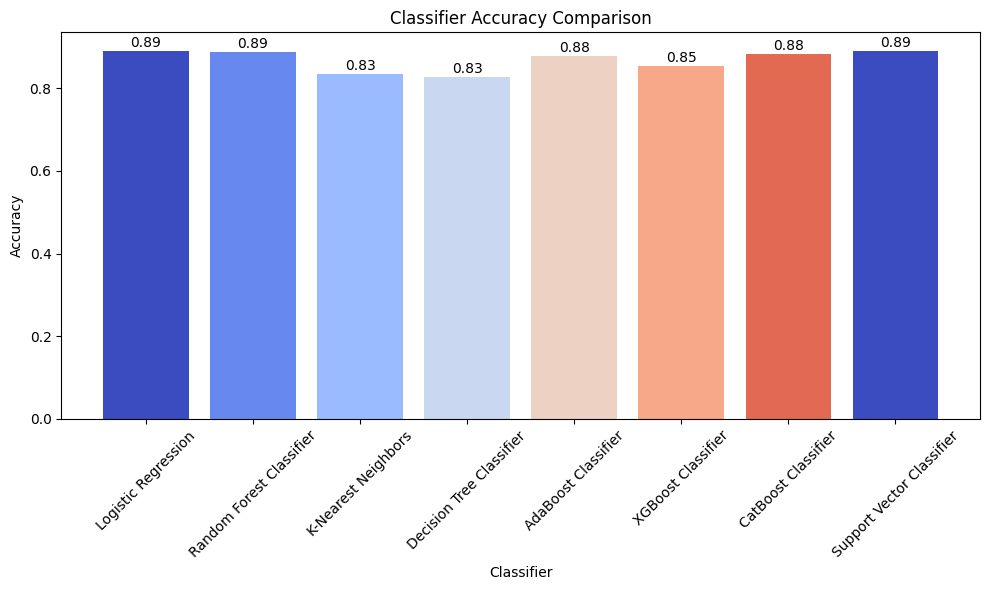

In [167]:

cmap = plt.get_cmap('coolwarm')

# Create a dictionary to map unique accuracy values to colors
unique_accuracies = list(set(accuracy_list))
color_mapping = {accuracy: cmap(i / len(unique_accuracies)) for i, accuracy in enumerate(unique_accuracies)}

# Map colors to each accuracy value
colors = [color_mapping[accuracy] for accuracy in accuracy_list]

# Plot the accuracy of different models with colored bars
plt.figure(figsize=(10, 6))
bars = plt.bar(model_list, accuracy_list, color=colors)  # Assign colors to bars

plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy Comparison')
plt.xticks(rotation=45)

# Add labels to each bar
for bar, accuracy in zip(bars, accuracy_list):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{accuracy:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# You can further evaluate and fine-tune the chosen classification model.


Logistic Regression,RF and SVC perform equally (94% accuracy). due to its Scalability, Logistic Regression is relatively easy to deploy and scale in production environments. SVMs can be more complex to deploy due to kernel choices and hyperparameter tuning.

## Logistic Regression

In [158]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score

# Create and fit the Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logistic = logistic_model.predict(X_test)

# Calculate the R2 score (Note: R2 score is typically used for regression, not classification)
# For classification, you may consider using other metrics like accuracy, precision, recall, etc.
# R2 score is not a suitable metric for classification tasks.
r2_logistic = r2_score(y_test, y_pred_logistic)

print("R2 Score for Logistic Regression: {:.4f}".format(r2_logistic))



R2 Score for Logistic Regression: 0.5638


##  y_pred and y_test plts

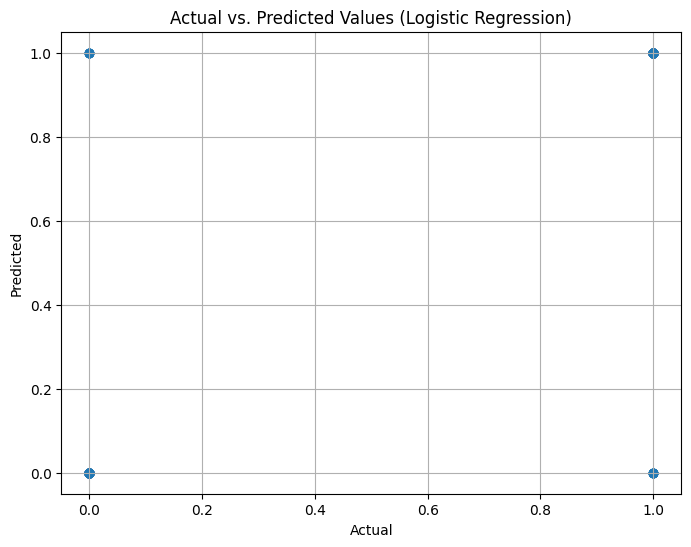

In [159]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_logistic, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (Logistic Regression)')
plt.grid(True)
plt.show()

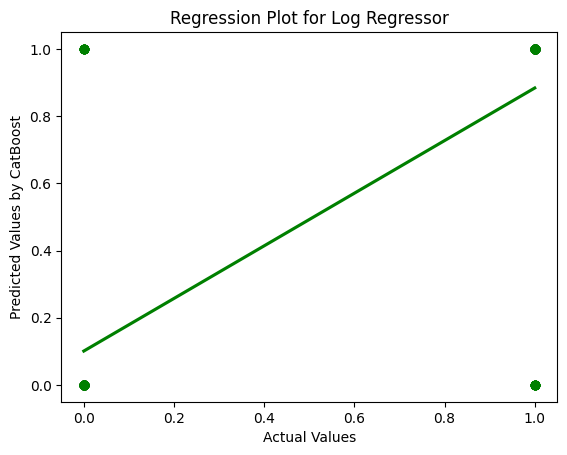

In [160]:
sns.regplot(x=y_test, y=y_pred_logistic, ci=None, color='green')

# Add labels and a title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values by CatBoost')
plt.title('Regression Plot for Log Regressor')

# Show the plot
plt.show()

### Actual and Pred values differences

In [161]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_logistic,'Difference':y_test-y_pred_logistic})
pred_df

,Actual Value,Predicted Value,Difference
415,1,1,0
259,1,1,0
332,1,1,0
622,1,0,1
101,0,0,0
...,...,...,...
649,1,0,1
976,0,0,0
178,1,1,0
31,0,1,-1


In [169]:
print("The max difference is:")
print(pred_df['Difference'].max())
print("\n")
print("The min difference is:")
print(pred_df['Difference'].min())


The max difference is:
1


The min difference is:
-1


# ________________AMAZING JOB!!! ________________________